# Clasificador de objetos simples usando regresión logística

Este cuaderno demuestra paso a paso cómo usar regresión logística para clasificar objetos simples. Se aplica la regresión logística a un subconjunto del dataset CIFAR-10.

## 1. Cargar el dataset CIFAR-10

CIFAR-10 es un conjunto de datos de imágenes en color (RGB) de tamaño 32×32 píxeles repartidas en 10 clases:

- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck

Utilizamos ``tensorflow.keras.datasets.cifar10`` para cargar el dataset en memoria.

In [10]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# Cargar datos
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f'Tamaño de x_train: {x_train.shape}')
print(f'Tamaño de x_test: {x_test.shape}')
print(f'Tamaño de y_train: {y_train.shape}')
print(f'Tamaño de y_test: {y_test.shape}')

Tamaño de x_train: (50000, 32, 32, 3)
Tamaño de x_test: (10000, 32, 32, 3)
Tamaño de y_train: (50000, 1)
Tamaño de y_test: (10000, 1)


In [11]:
# Aplanar las etiquetas (vienen como matrices de 1 columna)
y_train = y_train.flatten()
y_test = y_test.flatten()
# Mostrar tamaños
print(f'Tamaño de x_train: {x_train.shape}')
print(f'Tamaño de x_test: {x_test.shape}')
print(f'Tamaño de y_train: {y_train.shape}')
print(f'Tamaño de y_test: {y_test.shape}')

Tamaño de x_train: (50000, 32, 32, 3)
Tamaño de x_test: (10000, 32, 32, 3)
Tamaño de y_train: (50000,)
Tamaño de y_test: (10000,)


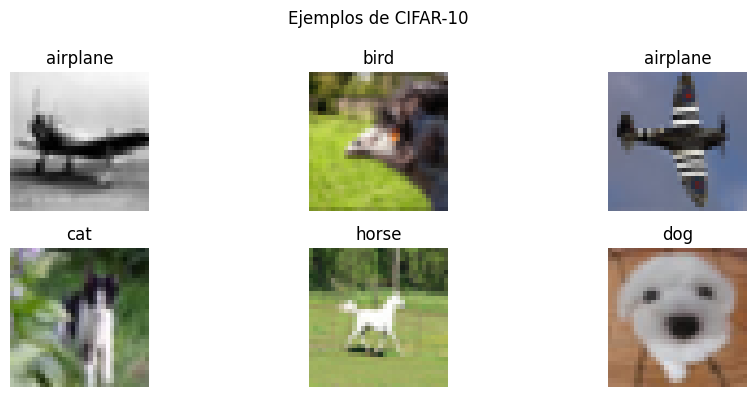

In [12]:
# Diccionario de nombres de clase
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Mostrar cimágenes aleatorias
idx = np.random.choice(len(x_train), 6, replace=False)
plt.figure(figsize=(10, 4))
for i, j in enumerate(idx):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_train[j])
    plt.title(class_names[y_train[j]])
    plt.axis('off')
plt.suptitle('Ejemplos de CIFAR-10')
plt.tight_layout()
plt.show()

## 2. Seleccionar dos clases para clasificación binaria

Para simplificar el problema a una clasificación binaria, seleccionamos dos clases cualesquiera. Podemos cambiar las variables ``class1_idx`` y ``class2_idx`` para elegir las clases deseadas. A continuación filtramos las imágenes de entrenamiento y prueba para quedarnos sólo con esas clases y relabelamos las etiquetas a 0 y 1.

In [13]:
# Elegir las dos clases (por ejemplo, gato=3 y perro=5)
class1_idx = 3  # gato
class2_idx = 5  # perro
print(f'Clase 1 (0): {class_names[class1_idx]}')
print(f'Clase 2 (1): {class_names[class2_idx]}')

# Crear máscaras para filtrar los datos
train_mask = np.isin(y_train, [class1_idx, class2_idx])
test_mask = np.isin(y_test, [class1_idx, class2_idx])

x_train_bin = x_train[train_mask]
y_train_bin = y_train[train_mask]
x_test_bin = x_test[test_mask]
y_test_bin = y_test[test_mask]

Clase 1 (0): cat
Clase 2 (1): dog


In [14]:
# Relabelar: clase1 -> 0, clase2 -> 1
y_train_bin = (y_train_bin == class2_idx).astype(int)
y_test_bin = (y_test_bin == class2_idx).astype(int)

print(f'Número de imágenes de entrenamiento binarias: {len(x_train_bin)}')
print(f'Número de imágenes de prueba binarias: {len(x_test_bin)}')

Número de imágenes de entrenamiento binarias: 10000
Número de imágenes de prueba binarias: 2000


## 3. Generar canales adicionales (HSV y bordes de Sobel)

Para cada imagen de CIFAR-10 obtenemos un conjunto de 8 canales de características:

- **RGB**: los 3 canales originales.
- **HSV**: convertimos la imagen a espacio de color HSV con `cv2.cvtColor` usando la bandera ``cv2.COLOR_RGB2HSV``.
- **Bordes de Sobel**: calculamos dos mapas de bordes (horizontal y vertical) a partir de la imagen en escala de grises utilizando ``cv2.Sobel``. El tamaño del kernel de Sobel ``ksize`` se puede ajustar (por defecto 3).

A continuación definimos una función ``extract_features`` que toma una imagen y devuelve un vector de características aplanado de longitud 8·32·32.

In [3]:
import cv2

def extract_features(image: np.ndarray, sobel_ksize: int = 3):
    """
    Extrae un vector de características de una imagen RGB de 32x32:

    - RGB original (3 canales)
    - HSV (3 canales)
    - Sobel horizontal y vertical sobre la escala de grises (2 canales)

    Devuelve un vector 1D de longitud 8*32*32 (8 canales x 32 width x 32 height)
    """
    # Normalizar a rango [0, 1]
    img_rgb = image.astype(np.float32) / 255.0

    # HSV
    img_hsv = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32) / 255.0

    # Escala de grises para bordes
    gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    # Sobel horizontal y vertical
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_ksize)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_ksize)

    # Normalizar bordes al rango [0, 1] usando valores absolutos
    sobelx_norm = cv2.normalize(np.abs(sobelx), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    sobely_norm = cv2.normalize(np.abs(sobely), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # Apilar canales en profundidad -> dimensiones: 32x32x8
    features = np.dstack((img_rgb, img_hsv, sobelx_norm[..., None], sobely_norm[..., None]))

    # Aplanar a vector
    return features.flatten()


### 3.1 Demostración con una imagen

Tomamos una imagen de la clase 0 y generamos sus canales RGB, HSV y de bordes. Visualizamos cada canal para entender qué información aporta.

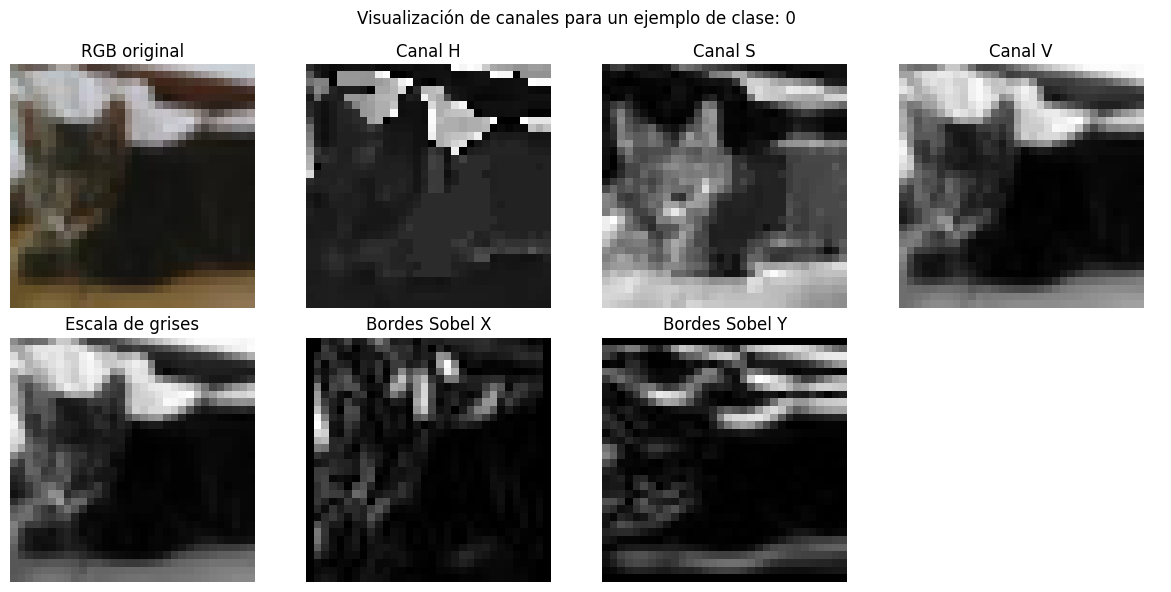

In [4]:
# Seleccionar un índice y extraer la imagen original (de la primera clase binaria)
sample_index = 0
sample_image = x_train_bin[sample_index]
sample_label = y_train_bin[sample_index]

# Convertir a HSV y bordes para visualización
img_rgb = sample_image.astype(np.float32) / 255.0
img_hsv = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32) / 255.0
gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
sobelx_norm = cv2.normalize(np.abs(sobelx), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
sobely_norm = cv2.normalize(np.abs(sobely), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Mostrar canales
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title('RGB original')
axes[0, 0].axis('off')

# HSV channels
for i, channel in enumerate(['H', 'S', 'V']):
    axes[0, i + 1].imshow(img_hsv[:, :, i], cmap='gray')
    axes[0, i + 1].set_title(f'Canal {channel}')
    axes[0, i + 1].axis('off')

# Sobel channels
axes[1, 0].imshow(gray, cmap='gray')
axes[1, 0].set_title('Escala de grises')
axes[1, 0].axis('off')
axes[1, 1].imshow(sobelx_norm, cmap='gray')
axes[1, 1].set_title('Bordes Sobel X')
axes[1, 1].axis('off')
axes[1, 2].imshow(sobely_norm, cmap='gray')
axes[1, 2].set_title('Bordes Sobel Y')
axes[1, 2].axis('off')

# Espacio en blanco para alineamiento
axes[1, 3].axis('off')

plt.suptitle(f'Visualización de canales para un ejemplo de clase: {sample_label}')
plt.tight_layout()
plt.show()

## 4. Construir funciones para el pipeline de clasificación

Definimos funciones que preparan el conjunto de datos completo para el entrenamiento de la regresión logística y realizan la clasificación. Estas funciones reusan ``extract_features`` para convertir cada imagen en un vector.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Nota: importamos seaborn dentro de la función de evaluación para evitar advertencias si no está instalado globalmente


def prepare_feature_matrix(images: np.ndarray, sobel_ksize: int = 3, max_samples: int = None) -> np.ndarray:
    """Convierte un conjunto de imágenes a una matriz de características.

    Args:
        images (np.ndarray): arreglo de imágenes de tamaño (N, 32, 32, 3).
        sobel_ksize (int): tamaño del filtro de Sobel.
        max_samples (int, opcional): si se especifica, limita el número de muestras para acelerar el procesamiento.

    Returns:
        np.ndarray: matriz de características de tamaño (N, 8192).
    """
    if max_samples is not None:
        images = images[:max_samples]

    n_samples = images.shape[0]
    # Prealocar matriz de características
    features = np.zeros((n_samples, 32 * 32 * 8), dtype=np.float32)

    for i in range(n_samples):
        features[i, :] = extract_features(images[i], sobel_ksize=sobel_ksize)
    return features


def train_logistic_regression(X_train: np.ndarray, y_train: np.ndarray, max_iter: int = 200) -> LogisticRegression:
    """Entrena un modelo de regresión logística."""
    clf = LogisticRegression(max_iter=max_iter, solver='lbfgs')
    clf.fit(X_train, y_train)
    return clf


def evaluate_model(clf: LogisticRegression, X_test: np.ndarray, y_test: np.ndarray):
    """Evalúa el modelo y devuelve el reporte de clasificación y la matriz de confusión."""
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return report, cm


## 5. Entrenamiento y evaluación del modelo

Usamos las funciones anteriores para preparar un subconjunto del dataset de entrenamiento y prueba. Para que el entrenamiento sea rápido en un cuaderno interactivo, limitamos el número de muestras a ``max_samples``. Puedes ajustar ``max_samples`` o dejarlo como ``None`` para usar todas las imágenes, aunque esto requerirá más tiempo y memoria.

Matriz de características de entrenamiento: (1000, 8192)
Matriz de características de prueba: (200, 8192)
Reporte de clasificación:               precision    recall  f1-score   support

           0       0.59      0.60      0.60       108
           1       0.52      0.51      0.52        92

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200

Matriz de confusión: [[65 43]
 [45 47]]


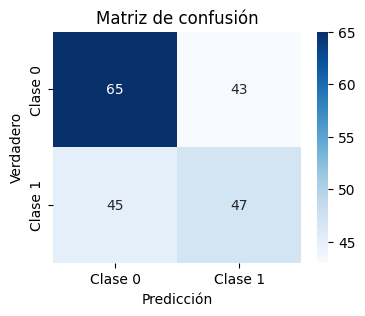

In [6]:
# Preparar matrices de características (limitar el número de muestras para acelerar)
max_train = 1000  # cambia a None para usar todas las muestras
max_test = 200

X_train_feat = prepare_feature_matrix(x_train_bin, sobel_ksize=3, max_samples=max_train)
X_test_feat = prepare_feature_matrix(x_test_bin, sobel_ksize=3, max_samples=max_test)

# Etiquetas correspondientes
y_train_sub = y_train_bin[:max_train] if max_train is not None else y_train_bin
y_test_sub = y_test_bin[:max_test] if max_test is not None else y_test_bin

print(f'Matriz de características de entrenamiento: {X_train_feat.shape}')
print(f'Matriz de características de prueba: {X_test_feat.shape}')

# Entrenar modelo
clf = train_logistic_regression(X_train_feat, y_train_sub, max_iter=200)

# Evaluar modelo
report, cm = evaluate_model(clf, X_test_feat, y_test_sub)
print('Reporte de clasificación:', report)
print('Matriz de confusión:', cm)

# Visualizar la matriz de confusión
import seaborn as sns
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión')
plt.show()